In [ ]:
!pip install transformers

In [ ]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load your train and test datasets
train = pd.read_csv('/content/eng_dep_covdtb_trains.csv')
test = pd.read_csv('/content/eng_dep_covdtb_test_results.csv')
test = test.drop('ChatGPT discourse relation', axis=1)

print(train.shape)
print(test.shape)

df = pd.concat([train, test], ignore_index=True)
print(df.shape)

(2399, 3)
(2585, 3)
(4984, 3)


In [ ]:
# create a binary column that indicates whether the relation is elaboration or not
df['Real discourse changed'] = ''
for i in range(len(df)):
  if df.iloc[i]['Real discourse relation'] == 'elaboration':
    df.loc[i]['Real discourse changed'] = 'elaboration'
  else:
    df.loc[i]['Real discourse changed'] = 'not elaboration'


In [ ]:
print(df['Real discourse changed'].isna().sum())

0


In [ ]:
df.head()

,EDU_1,EDU_2,Real discourse relation,Real discourse changed
0,Background :,EU Decision 1082/2013 / EU on serious cross - ...,textual-organization,not elaboration
1,EU Decision 1082/2013 / EU on serious cross - ...,this qualitative case study has investigated s...,background,not elaboration
2,EU Decision 1082/2013 / EU on serious cross - ...,The Decision provides a context for the presen...,elaboration,elaboration
3,The Decision provides a context for the presen...,which aims to identify good practices and lessons,enablement,not elaboration
4,which aims to identify good practices and lessons,learned in preparedness and response to Middle...,elaboration,elaboration


In [ ]:
label_encoder = LabelEncoder()
df['Real discourse relation encoded'] = label_encoder.fit_transform(df['Real discourse changed'])

relations = df['Real discourse changed'].unique()

print(df.shape)

train_data = df[:int(len(df)*0.8)] 
test_data = df[int(len(df)*0.8):]   
print(df.head(1))

print(df['Real discourse relation encoded'].unique())

(4984, 5)
          EDU_1                                              EDU_2  \
0  Background :  EU Decision 1082/2013 / EU on serious cross - ...   

  Real discourse relation Real discourse changed  \
0    textual-organization        not elaboration   

   Real discourse relation encoded  
0                                1  
[1 0]


In [ ]:
df.head()

,EDU_1,EDU_2,Real discourse relation,Real discourse changed,Real discourse relation encoded
0,Background :,EU Decision 1082/2013 / EU on serious cross - ...,textual-organization,not elaboration,1
1,EU Decision 1082/2013 / EU on serious cross - ...,this qualitative case study has investigated s...,background,not elaboration,1
2,EU Decision 1082/2013 / EU on serious cross - ...,The Decision provides a context for the presen...,elaboration,elaboration,0
3,The Decision provides a context for the presen...,which aims to identify good practices and lessons,enablement,not elaboration,1
4,which aims to identify good practices and lessons,learned in preparedness and response to Middle...,elaboration,elaboration,0


In [ ]:
# Define a custom dataset class
class SentencePairDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        first_sentence = str(self.data.iloc[index]['EDU_1'])
        second_sentence = str(self.data.iloc[index]['EDU_2'])
        relation_label = int(self.data.iloc[index]['Real discourse relation encoded'])

        # Tokenize the input sentences
        inputs = self.tokenizer(first_sentence, second_sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(relation_label, dtype=torch.long)
        }

# Initialize a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets and data loaders
train_dataset = SentencePairDataset(train_data, tokenizer)
test_dataset = SentencePairDataset(test_data, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)
print(train_dataloader)

# Initialize and fine-tune a BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Assuming 3 relation classes (positive, negative, neutral)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Fine-tune the model on the training data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(3): 
    print(epoch)
    for batch in train_dataloader:
        print("no")
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluate the model on the test data
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        print("yes")
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.numpy())


In [ ]:
test_data['BERT predicted relation'] = predictions

In [ ]:
test_data.tail()

,EDU_1,EDU_2,Real discourse relation,Real discourse changed,Real discourse relation encoded,BERT predicted relation
4979,which needs to be adhered to,while receiving the human body of a donor and ...,temporal,not elaboration,1,1
4980,The review highlights on the ethical norms,It reflects on ideal ethical behaviour in the ...,elaboration,elaboration,0,0
4981,It reflects on ideal ethical behaviour in the ...,and finally emphasize on the respectful dispos...,elaboration,elaboration,0,0
4982,The present review is an attempt,The intended purpose of this article is to sup...,enablement,not elaboration,1,1
4983,The intended purpose of this article is to sup...,used in anatomical dissection .,elaboration,elaboration,0,0


In [ ]:
from sklearn.metrics import accuracy_score

print("Accuracy score = " + str(accuracy_score(test_data['Real discourse relation encoded'], test_data['BERT predicted relation'])))

Accuracy score = 0.8124373119358074


In [ ]:
test_data['Real discourse relation encoded'].unique()

array([1, 0])

In [ ]:
decoded_predictions = label_encoder.inverse_transform(predictions)
decoded_true_labels = label_encoder.inverse_transform(true_labels)

accuracy_score(decoded_true_labels, decoded_predictions)

0.8124373119358074

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

f1_score(decoded_true_labels, decoded_predictions, average='weighted')

0.8115409087158458

In [ ]:
import numpy as np

np.unique(decoded_predictions)

array(['elaboration', 'not elaboration'], dtype=object)

In [ ]:
test_data['BERT predicted relation decoded'] = decoded_predictions

In [ ]:
df['Real discourse relation'].unique()

array(['textual-organization', 'background', 'elaboration', 'enablement',
       'manner-means', 'findings', 'comparison', 'cause-result',
       'condition', 'attribution', 'joint', 'temporal'], dtype=object)

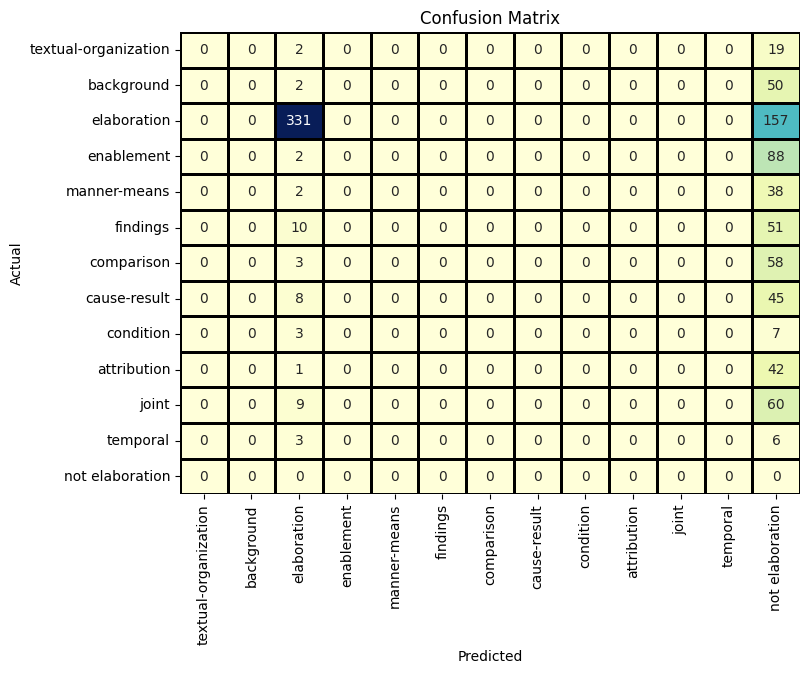

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

relations = ['textual-organization', 'background', 'elaboration', 'enablement',
       'manner-means', 'findings', 'comparison', 'cause-result',
       'condition', 'attribution', 'joint', 'temporal', 'not elaboration']
# relatons.append('not elaboration')
conf_matrix = confusion_matrix(test_data["Real discourse relation"].astype(str), test_data["BERT predicted relation decoded"].astype(str), labels=relations)
confusion_df = pd.DataFrame(conf_matrix, index=relations, columns=relations)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", linewidths=1, linecolor="black", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()